In [1]:
%matplotlib inline
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, LSTM, GRU, Dense, Activation, Dropout, MaxPooling1D, Flatten, Merge, Reshape
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils
import keras_pooling
reload(nn_utils)
reload(keras_pooling)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split

import tqdm
import cPickle

Using Theano backend.


In [3]:
num_filters = [64,64,32]
filter_length = [6,6,6]

model1 = Sequential()
model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model1.add(Dropout(0.25))
model1.add(Convolution1D(num_filters[1], filter_length[1], activation='relu'))
model1.add(MaxPooling1D(2))
model1.add(Convolution1D(num_filters[2], filter_length[2], activation='relu'))
model1.add(keras_pooling.SumLayer())
model1.add(Reshape((num_filters[2],)))
#model1.add(Flatten())
#model1.add(Dense(output_dim=1, activation='linear'))
#model1.add(Activation('sigmoid'))

model2 = Sequential()
model2.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model2.add(Dropout(0.25))
model2.add(Convolution1D(num_filters[1], filter_length[1], activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(Convolution1D(num_filters[2], filter_length[2], activation='relu'))
model2.add(keras_pooling.SumLayer())
model2.add(Reshape((num_filters[2],)))

#model2.add(Flatten())

model3 = Sequential()
model3.add(Merge([model1, model2], mode='concat', concat_axis=1))
model3.add(Dense(output_dim=4, activation='linear'))
model3.add(Activation('sigmoid'))

In [2]:
X_train, X_test, Y_train, Y_test = nn_utils.load_a5_data()
X1_train = X_train.map(lambda x: x[0:25])
X2_train = X_train.map(lambda x: x[25:])
X1_test = X_test.map(lambda x: x[0:25])
X2_test = X_test.map(lambda x: x[25:])

#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_train = np.dstack(X1_train)
X1_train = np.rollaxis(X1_train, 2)
X1_test = np.dstack(X1_test)
X1_test = np.rollaxis(X1_test, 2)

X2_train = np.dstack(X2_train)
X2_train = np.rollaxis(X2_train, 2)
X2_test = np.dstack(X2_test)
X2_test = np.rollaxis(X2_test, 2)

Y1_test = Y_test[:,0]
Y1_train = Y_train[:,0]
Y2_test = Y_test[:,44]
Y2_train = Y_train[:,44]
Y3_test = Y_test[:,79]
Y3_train = Y_train[:,79]
Yn_test = 1 - Y1_test - Y2_test - Y3_test #Y_test[:,303]
Yn_train = 1 - Y1_train - Y2_train - Y3_train #Y_train[:,303]
Y_test_small = np.dstack([Y1_test, Y2_test, Y3_test, Yn_test])
Y_train_small = np.dstack([Y1_train, Y2_train, Y3_train, Yn_train])
Y_test_small = Y_test_small.reshape(
    (Y_test_small.shape[1], Y_test_small.shape[2]))
Y_train_small = Y_train_small.reshape(
    (Y_train_small.shape[1], Y_train_small.shape[2]))

In [5]:
model3.compile(loss='categorical_crossentropy',
              optimizer='adam')

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model3.fit([X1_train, X2_train], Y_train_small,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=([X1_test, X2_test], Y_test_small),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 296s - loss: 1.0511 - val_loss: 0.9514
Epoch 2/50
212035/212035 [==============================] - 300s - loss: 0.9328 - val_loss: 0.8990
Epoch 3/50
212035/212035 [==============================] - 304s - loss: 0.9000 - val_loss: 0.8698
Epoch 4/50
212035/212035 [==============================] - 318s - loss: 0.8825 - val_loss: 0.8635
Epoch 5/50
212035/212035 [==============================] - 314s - loss: 0.8715 - val_loss: 0.8565
Epoch 6/50
212035/212035 [==============================] - 301s - loss: 0.8660 - val_loss: 0.8470
Epoch 7/50
212035/212035 [==============================] - 323s - loss: 0.8602 - val_loss: 0.8498
Epoch 8/50
212035/212035 [==============================] - 307s - loss: 0.8552 - val_loss: 0.8430
Epoch 9/50
212035/212035 [==============================] - 308s - loss: 0.8524 - val_loss: 0.8411
Epoch 10/50
212035/212035 [==============================]

/usr/local/lib/python2.7/dist-packages/keras/models.py:380: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


In [7]:
predictions = model3.predict([X1_test, X2_test])

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


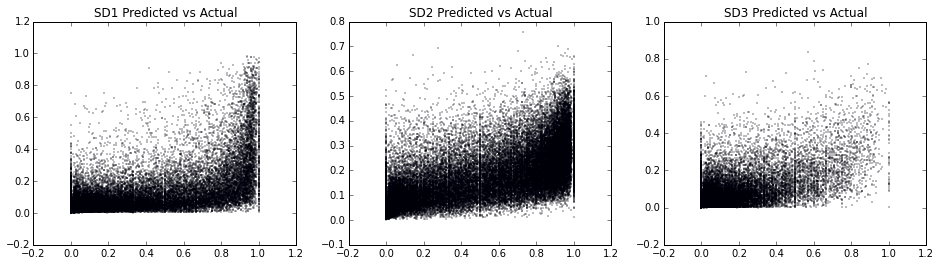

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4), squeeze=True)
axes[0].set_title('SD1 Predicted vs Actual')
axes[0].scatter(Y_test_small[:,0], predictions[:,0], s=0.1)
axes[1].set_title('SD2 Predicted vs Actual')
axes[1].scatter(Y_test_small[:,1], predictions[:,1], s=0.1)
axes[2].set_title('SD3 Predicted vs Actual')
axes[2].scatter(Y_test_small[:,2], predictions[:,2], s=0.1)

fig.subplots_adjust(hspace=0.4)
plt.show()

In [67]:
from keras import backend as K

expit = lambda x: 1./(1.+np.exp(-x))
logit = lambda x: np.log(x)-np.log(1-x)

# new in keras 1.0: need a learning phase argument
get_3rd_layer_output_1 = K.function([model1.layers[0].input, model2.layers[0].input, K.learning_phase()],
                                  [model3.layers[-2].output])
def get_score(input_data):
    return get_3rd_layer_output_1([input_data, np.zeros(input_data.shape), 1])[0][0][1]
    #return (get_3rd_layer_output_2([input_data])[0] + get_3rd_layer_output_1([input_data])[0])/2

def get_delta_psi(wt_seq, mut_seq, wt_psi):
    score_wt = get_score(wt_seq)
    score_mut = get_score(mut_seq)
    mut_psi = expit(score_mut - score_wt + logit(wt_psi))
    return mut_psi - wt_psi

In [59]:
table1 = pd.read_table('../data/mmc2.tsv')
wt_seqs = table1.WT_SEQ
mut_seqs = table1.MUT_SEQ
wt_seqs_encoded = [nn_utils.seq_to_array(x) for x in wt_seqs]
mut_seqs_encoded = [nn_utils.seq_to_array(x) for x in mut_seqs]
wt_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), wt_seqs_encoded)
mut_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), mut_seqs_encoded)

In [68]:
nn_delta_psi = [get_delta_psi(w, m, p) for w, m, p in tqdm.tqdm(zip(wt_seqs_encoded, mut_seqs_encoded, table1.WT_PSI))]

In [69]:
model_dpsi_pred = [x for x in nn_delta_psi]

In [70]:
hal_pred_2 = []
model_pred_2 = []
actual = []
pos_or_neg = []
for h, m, a in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred, table1.HOMO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)
        if h>=0 and m>=0:
            pos_or_neg.append(1)
        elif h<=0 and m<=0:
            pos_or_neg.append(0)

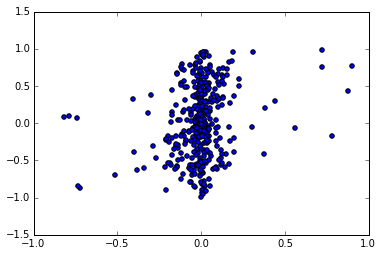

In [71]:
plt.scatter(actual, model_pred_2)

In [72]:
model_pred_2 = np.array(model_pred_2)
actual = np.array(actual)
r2_score(model_pred_2-model_pred_2.mean(), actual-actual.mean())

0.038408267531039542

In [66]:
get_3rd_layer_output_1([wt_seqs_encoded[0], wt_seqs_encoded[0], 1])[0][0][0]

-478.73022

## New Model...

In [39]:
num_filters = [128,64,32,32]
filter_length = [6,6,5,4]

model1 = Sequential()
model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model1.add(Dropout(0.25))
model1.add(Convolution1D(num_filters[1], filter_length[1], activation='relu'))
model1.add(MaxPooling1D(2))
model1.add(Convolution1D(num_filters[2], filter_length[2], activation='relu'))
#model1.add(MaxPooling1D(2))
#model1.add(Convolution1D(num_filters[3], filter_length[3], activation='relu'))
#model1.add(MaxPooling1D(2))
model1.add(keras_pooling.SumLayer())
model1.add(Reshape((num_filters[3],)))
#model1.add(Flatten())
#model1.add(Dense(output_dim=1, activation='linear'))
#model1.add(Activation('sigmoid'))

model2 = Sequential()
model2.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model2.add(Dropout(0.25))
model2.add(Convolution1D(num_filters[1], filter_length[1], activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(Convolution1D(num_filters[2], filter_length[2], activation='relu'))
#model2.add(MaxPooling1D(2))
#model2.add(Convolution1D(num_filters[3], filter_length[3], activation='relu'))
#model2.add(MaxPooling1D(2))
model2.add(keras_pooling.SumLayer())
model2.add(Reshape((num_filters[3],)))

#model2.add(Flatten())

model3 = Sequential()
model3.add(Merge([model1, model2], mode='concat', concat_axis=1))
model3.add(Dense(output_dim=4, activation='linear'))
model3.add(Activation('sigmoid'))

In [40]:
model3.compile(loss='categorical_crossentropy',
              optimizer='adam')

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model3.fit([X1_train, X2_train], Y_train_small,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=([X1_test, X2_test], Y_test_small),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 599s - loss: 1.0384 - val_loss: 0.9533
Epoch 2/50
212035/212035 [==============================] - 603s - loss: 0.9158 - val_loss: 0.8860
Epoch 3/50
212035/212035 [==============================] - 601s - loss: 0.8848 - val_loss: 0.8733
Epoch 4/50
212035/212035 [==============================] - 605s - loss: 0.8716 - val_loss: 0.8672
Epoch 5/50
212035/212035 [==============================] - 597s - loss: 0.8628 - val_loss: 0.8487
Epoch 6/50
212035/212035 [==============================] - 574s - loss: 0.8569 - val_loss: 0.8465
Epoch 7/50
212035/212035 [==============================] - 591s - loss: 0.8530 - val_loss: 0.8415
Epoch 8/50
212035/212035 [==============================] - 622s - loss: 0.8496 - val_loss: 0.8399
Epoch 9/50
212035/212035 [==============================] - 628s - loss: 0.8471 - val_loss: 0.8418
Epoch 10/50
212035/212035 [==============================]

KeyboardInterrupt: 

## New New Model